Special Issues

In [15]:
import pickle
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

with open(r'D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\jocs_bge_m3.pkl', 'rb') as f:
    jocs_data = pickle.load(f)

with open(r'D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\iccs_bge_m3.pkl', 'rb') as f:
    iccs_data = pickle.load(f)


# DOI Extraction
def get_doi(filename):
    if pd.isna(filename): return "N/A"
    # Extension hatayen aur pehlay underscore ke baad ka sara hissa DOI hai
    # Example: '2001_10.1007_3-540-45545-0_115.json' -> '10.1007_3-540-45545-0_115'
    parts = filename.replace(".json", "").split("_", 1)
    return parts[1] if len(parts) > 1 else "N/A"

# Metadata mein DOI column foran add karein
iccs_data['df_metadata']['doi'] = iccs_data['df_metadata']['filename'].apply(get_doi)
jocs_data['df_metadata']['doi'] = jocs_data['df_metadata']['filename'].apply(get_doi)

# 3. Fast Semantic Matching (Vectorized)
# Har ICCS paper ko har JoCS paper ke saath compare karein
sim_matrix = cosine_similarity(iccs_data['embeddings'], jocs_data['embeddings'])

# Threshold: 0.90 (Matlab 90% semantic similarity)
threshold = 0.78
iccs_indices, jocs_indices = np.where(sim_matrix > threshold)

matches = []

# 4. Filter aur Match list banana
# Updated loop logic for your evolution analysis
for i, j in zip(iccs_indices, jocs_indices):
    iccs_row = iccs_data['df_metadata'].iloc[i]
    jocs_row = jocs_data['df_metadata'].iloc[j]
    
    if jocs_row['year'] >= iccs_row['year']:
        # 1. Extract raw DOI from filename (e.g., 10.1007_978...)
        raw_iccs_doi = get_doi(iccs_row['filename'])
        raw_jocs_doi = get_doi(jocs_row['filename'])
        
        # 2. Logic to replace ONLY the first underscore with a slash
        clean_iccs_doi = raw_iccs_doi.replace('_', '/', 1) if raw_iccs_doi != "N/A" else "N/A"
        clean_jocs_doi = raw_jocs_doi.replace('_', '/', 1) if raw_jocs_doi != "N/A" else "N/A"
        
        matches.append({
            'title': iccs_row['title'],
            'iccs_doi': clean_iccs_doi,
            'jocs_doi': clean_jocs_doi,
            'evolution_score': sim_matrix[i, j],
            'time_lag': jocs_row['year'] - iccs_row['year'],
            'iccs_year': iccs_row['year'],
            'jocs_year': jocs_row['year']
        })

# Save results
df_evolution = pd.DataFrame(matches).drop_duplicates(subset=['iccs_doi', 'jocs_doi'])
df_evolution.to_csv("evolution_all_years.csv", index=False)

print(f"Done! Found {len(df_evolution)} evolved papers with DOI.")

Done! Found 319 evolved papers with DOI.


Offical Special Issues<br>
DOI Extraction

In [16]:
import re
from pathlib import Path
import pandas as pd

TXT_DIR = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\special issues JOCS")

# Matches both:
#  - https://doi.org/10.1016/j.jocs.2014.10.004
#  - 10.1016/j.jocs.2014.10.004
DOI_REGEX = re.compile(r"(?:https?://doi\.org/)?(10\.\d{4,9}/[^\s)]+)", re.IGNORECASE)

def normalize_doi(doi: str) -> str:
    doi = doi.strip().lower()
    # remove trailing punctuation commonly attached in text
    doi = doi.rstrip(".,;:)[]}")
    return doi

rows = []
for txt_path in sorted(TXT_DIR.glob("*.txt")):
    year_tag = txt_path.stem  # e.g., "2014"
    text = txt_path.read_text(encoding="utf-8", errors="ignore")

    found = DOI_REGEX.findall(text)
    found = [normalize_doi(d) for d in found]

    # Keep only JoCS DOIs (you can loosen this if needed)
    found = [d for d in found if d.startswith("10.1016/j.jocs")]

    for doi in sorted(set(found)):
        rows.append({"source_file": txt_path.name, "source_year_file": year_tag, "official_doi": doi})

df_official = pd.DataFrame(rows).drop_duplicates(subset=["official_doi"]).sort_values(["official_doi"])

print("Files scanned:", len(list(TXT_DIR.glob("*.txt"))))
print("Unique official JoCS DOIs extracted:", len(df_official))

out_csv = TXT_DIR / "official_jocs_special_issue_dois.csv"
df_official.to_csv(out_csv, index=False)
print("Saved:", out_csv)


Files scanned: 11
Unique official JoCS DOIs extracted: 280
Saved: D:\ITMO Big Data & ML School\semester 3\RI3\special issues JOCS\official_jocs_special_issue_dois.csv


In [31]:
import pandas as pd
from pathlib import Path

TXT_DIR = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\special issues JOCS")

df_official = pd.read_csv(TXT_DIR / "official_jocs_special_issue_dois.csv")
official_set = set(df_official["official_doi"].str.lower().str.strip())

df_evolution = pd.read_csv(r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\evolution_all_years.csv")

# normalize your jocs_doi the same way
df_evolution["jocs_doi_norm"] = (
    df_evolution["jocs_doi"].astype(str).str.lower().str.strip().str.rstrip(".,;:)[]}")
)

df_evolution["is_official_si"] = df_evolution["jocs_doi_norm"].isin(official_set)

df_formal = df_evolution[df_evolution["is_official_si"]].copy()
df_organic = df_evolution[~df_evolution["is_official_si"]].copy()

df_formal.to_csv("paper_evolution_formal_official_si.csv", index=False)
df_organic.to_csv("paper_evolution_organic_nonofficial.csv", index=False)

print("All Matches:", len(df_evolution))
print("Editorial Evolution:", len(df_formal))
print("Semantic Evolution:", len(df_organic))


All Matches: 319
Editorial Evolution: 187
Semantic Evolution: 132


In [32]:
import pandas as pd

df_evolution = pd.read_csv(r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\evolution_all_years.csv")

# normalize
df_evolution["jocs_year"] = df_evolution["jocs_year"].astype(int)

# load official labels again if needed
df_official = pd.read_csv(
    r"D:\ITMO Big Data & ML School\semester 3\RI3\special issues JOCS\official_jocs_special_issue_dois.csv"
)
official_set = set(df_official["official_doi"].str.lower().str.strip())

df_evolution["jocs_doi_norm"] = (
    df_evolution["jocs_doi"].astype(str).str.lower().str.strip().str.rstrip(".,;:)[]}")
)
df_evolution["type"] = df_evolution["jocs_doi_norm"].apply(
    lambda x: "Editorial Evolution" if x in official_set else "Semantic Evolution"
)

# Year-wise counts
yearly_counts = (
    df_evolution
    .groupby(["jocs_year", "type"])
    .size()
    .unstack(fill_value=0)
    .sort_index()
)

print(yearly_counts)


type       Editorial Evolution  Semantic Evolution
jocs_year                                         
2010                         0                  14
2011                         0                   1
2012                         0                   7
2013                         0                   8
2014                         0                  10
2015                        21                   5
2016                         0                  13
2017                        10                  10
2018                        15                   4
2019                         9                  10
2020                        14                   5
2021                        25                   3
2022                        20                  17
2023                        26                   5
2024                        19                   9
2025                        28                  11


<Figure size 1200x600 with 0 Axes>

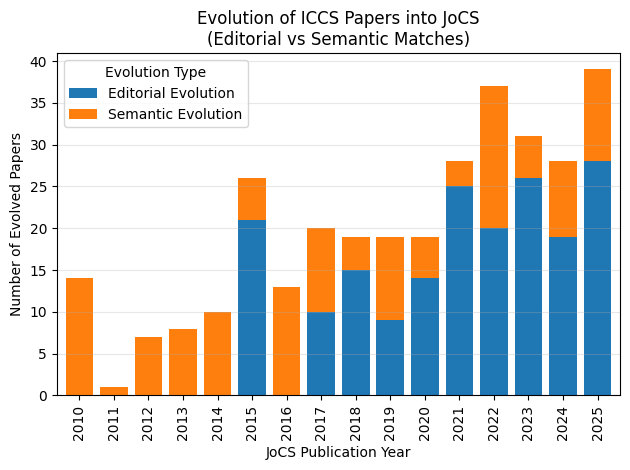

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

yearly_counts.plot(
    kind="bar",
    stacked=True,
    width=0.8
)

plt.title("Evolution of ICCS Papers into JoCS\n(Editorial vs Semantic Matches)")
plt.xlabel("JoCS Publication Year")
plt.ylabel("Number of Evolved Papers")

plt.legend(title="Evolution Type")
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


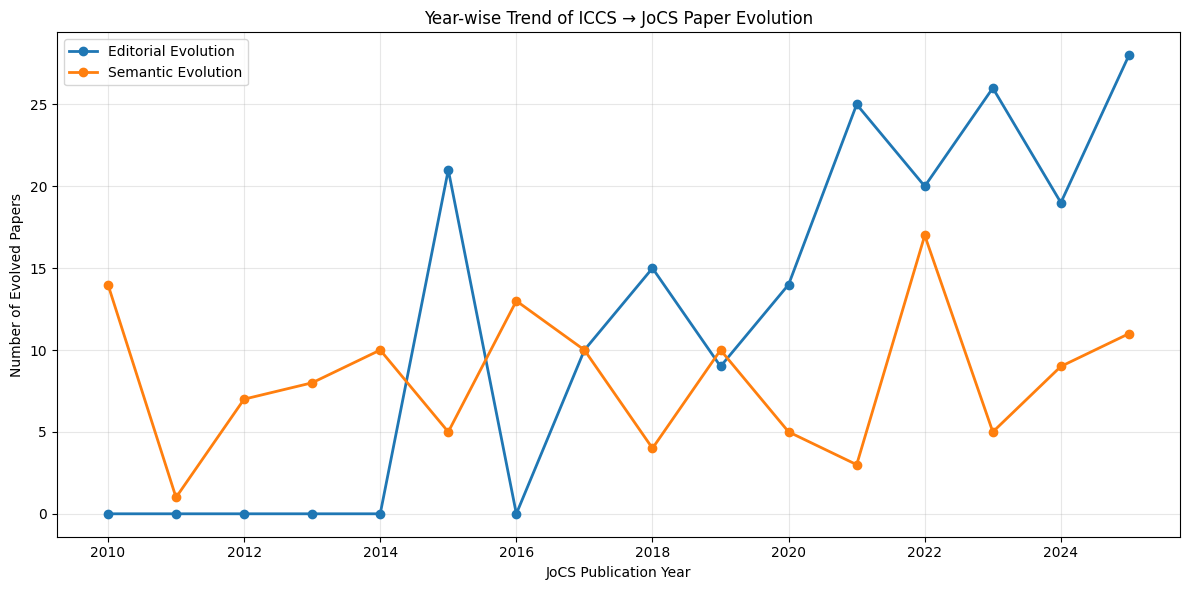

: 

In [ ]:
plt.figure(figsize=(12,6))

for col in yearly_counts.columns:
    plt.plot(
        yearly_counts.index,
        yearly_counts[col],
        marker="o",
        linewidth=2,
        label=col
    )

plt.title("Year-wise Trend of ICCS → JoCS Paper Evolution")
plt.xlabel("JoCS Publication Year")
plt.ylabel("Number of Evolved Papers")

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [21]:
df_formal = df_evolution[df_evolution["type"] == "Formal (Official SI)"]
df_formal["time_lag"].describe()


count    187.000000
mean       1.133690
std        1.030862
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       10.000000
Name: time_lag, dtype: float64

Citation Comparison Regular JOCS Vs Special Issues of ICCS in JOCS

In [26]:
import pandas as pd
import numpy as np

JOCS_FILE = r"D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\data\interim\jocs\JoCS_merged_data.jsonl"
OFFICIAL_DOI_FILE = r"D:\ITMO Big Data & ML School\semester 3\RI3\special issues JOCS\official_jocs_special_issue_dois.csv"
CURRENT_YEAR = 2026

# Load jsonl
df = pd.read_json(JOCS_FILE, lines=True)

# --- DOI normalize ---
df["doi_norm"] = (
    df["normalized_doi"]
    .astype(str)
    .str.lower()
    .str.strip()
    .str.rstrip(".,;:)[]}")
)

# --- Extract year safely ---
# Prefer OpenAlex publication_year if present; else use dblp_year
oa_year = df["openalex_work"].apply(lambda x: x.get("publication_year") if isinstance(x, dict) else np.nan)
df["year"] = pd.to_numeric(oa_year, errors="coerce")

# fallback to dblp_year where openalex year missing
df["year"] = df["year"].fillna(pd.to_numeric(df["dblp_year"], errors="coerce"))

# drop rows where year still missing
df = df.dropna(subset=["year"]).copy()
df["year"] = df["year"].astype(int)

# --- Extract citations safely ---
# Use OpenAlex cited_by_count if available; else 0
df["citations"] = df["openalex_work"].apply(
    lambda x: x.get("cited_by_count", 0) if isinstance(x, dict) else 0
).fillna(0).astype(int)

# Load official special issue DOIs
df_official = pd.read_csv(OFFICIAL_DOI_FILE)
official_set = set(df_official["official_doi"].astype(str).str.lower().str.strip())

# Label issue type
df["issue_type"] = np.where(
    df["doi_norm"].isin(official_set),
    "Special Issue (ICCS)",
    "Regular Issue"
)

# citations per year
df["citations_per_year"] = df["citations"] / (CURRENT_YEAR - df["year"] + 1)

# Stats table (robust)
stats = (
    df.groupby("issue_type")
      .agg(
          papers=("citations", "count"),
          median_citations=("citations", "median"),
          mean_citations=("citations", "mean"),
          median_cit_per_year=("citations_per_year", "median"),
          p75_citations=("citations", lambda x: x.quantile(0.75)),
          p90_citations=("citations", lambda x: x.quantile(0.90)),
      )
      .round(2)
)

print("\n=== CITATION COMPARISON (ALL YEARS) ===")
print(stats)

# Optional: post-2015 fairness
df_post = df[df["year"] >= 2015]

stats_post = (
    df_post.groupby("issue_type")
           .agg(
               papers=("citations", "count"),
               median_citations=("citations", "median"),
               median_cit_per_year=("citations_per_year", "median"),
               p90_citations=("citations", lambda x: x.quantile(0.90)),
           )
           .round(2)
)

print("\n=== CITATION COMPARISON (POST-2015) ===")
print(stats_post)



=== CITATION COMPARISON (ALL YEARS) ===
                      papers  median_citations  mean_citations  \
issue_type                                                       
Regular Issue           1826               8.0           29.69   
Special Issue (ICCS)     280               9.0           17.79   

                      median_cit_per_year  p75_citations  p90_citations  
issue_type                                                               
Regular Issue                        1.20           20.0           44.5  
Special Issue (ICCS)                 1.33           20.0           45.1  

=== CITATION COMPARISON (POST-2015) ===
                      papers  median_citations  median_cit_per_year  \
issue_type                                                            
Regular Issue           1525               8.0                 1.33   
Special Issue (ICCS)     272               9.0                 1.32   

                      p90_citations  
issue_type                        

<Figure size 800x600 with 0 Axes>

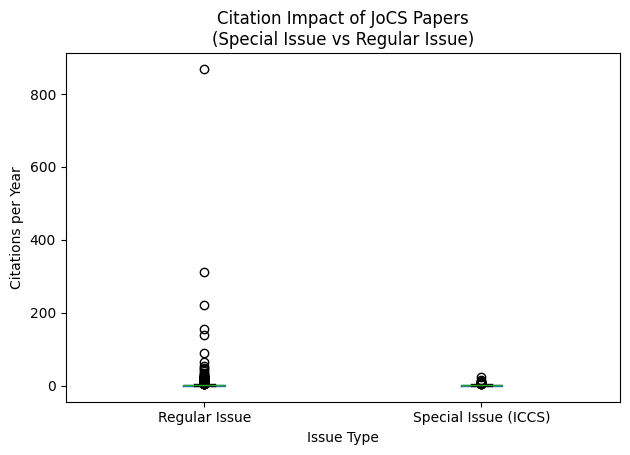

In [27]:
import matplotlib.pyplot as plt

# Sirf zaroori columns
plot_df = df[["issue_type", "citations_per_year"]].copy()

plt.figure(figsize=(8,6))

plot_df.boxplot(
    column="citations_per_year",
    by="issue_type",
    grid=False
)

plt.title("Citation Impact of JoCS Papers\n(Special Issue vs Regular Issue)")
plt.suptitle("")  # remove default subtitle
plt.xlabel("Issue Type")
plt.ylabel("Citations per Year")

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

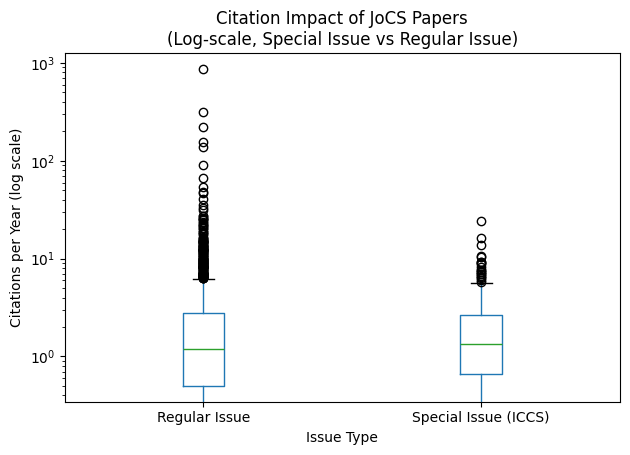

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

df.boxplot(
    column="citations_per_year",
    by="issue_type",
    grid=False,
    showfliers=True
)

plt.yscale("log")

plt.title("Citation Impact of JoCS Papers\n(Log-scale, Special Issue vs Regular Issue)")
plt.suptitle("")
plt.xlabel("Issue Type")
plt.ylabel("Citations per Year (log scale)")

plt.tight_layout()
plt.show()


# TF IDF Vs Semantic
From Frequency to Intent

In [7]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import pickle

# Load classified data
jocs_tf = pd.read_csv(r'D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\jocs_classified.csv')
iccs_tf = pd.read_csv(r'D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\iccs_classified.csv')

# Load embeddings
jocs_bge_data = np.load(r'D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\jocs_bge_m3.pkl', allow_pickle=True)
iccs_bge_data = np.load(r'D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\iccs_bge_m3.pkl', allow_pickle=True)
wiki_bge = pickle.load(open(r'D:\ITMO Big Data & ML School\semester 3\RI3\notebooks\previous_experiments\wiki_bge_m3.pkl', 'rb'))

# Extract arrays
jocs_bge = jocs_bge_data['embeddings']
iccs_bge = iccs_bge_data['embeddings']
wiki_emb = wiki_bge['embeddings']
wiki_names = wiki_bge['disciplines']

print("Data loaded:")
print(f"JOCS TF: {jocs_tf.shape}, BGE: {jocs_bge.shape}")
print(f"ICCS TF: {iccs_tf.shape}, BGE: {iccs_bge.shape}")
print(f"Wiki: {wiki_emb.shape}")

# BGE classification
jocs_sim = cosine_similarity(jocs_bge, wiki_emb)
jocs_pred_idx = np.argmax(jocs_sim, axis=1)
jocs_pred_names = np.array(wiki_names)[jocs_pred_idx]

iccs_sim = cosine_similarity(iccs_bge, wiki_emb)
iccs_pred_idx = np.argmax(iccs_sim, axis=1)
iccs_pred_names = np.array(wiki_names)[iccs_pred_idx]

# JoCS comparison (main)
jocs_comp = pd.DataFrame({
    'tf_pred': jocs_tf['predicted_discipline'],
    'bge_pred': jocs_pred_names,
    'tf_score': jocs_tf['sim_score'],
    'bge_score': jocs_sim.max(axis=1)
})

jocs_acc = (jocs_comp['tf_pred'] == jocs_comp['bge_pred']).mean()

# Results
print(f"\nJoCS Results:")
print(f"Agreement: {jocs_acc:.1%}")
print("\nTF-IDF Top 5:")
print(jocs_tf['predicted_discipline'].value_counts().head().to_string())
print("\nBGE-M3 Top 5:")
print(pd.Series(jocs_pred_names).value_counts().head().to_string())

# Save
jocs_comp.to_csv('jocs_comparison.csv', index=False)
print(f"\nSaved: jocs_comparison.csv ({len(jocs_comp)} rows)")

# ICCS if column exists
if 'predicted_discipline' in iccs_tf.columns:
    iccs_comp = pd.DataFrame({
        'tf_pred': iccs_tf['predicted_discipline'],
        'bge_pred': iccs_pred_names,
        'bge_score': iccs_sim.max(axis=1)
    })
    iccs_acc = (iccs_comp['tf_pred'] == iccs_comp['bge_pred']).mean()
    print(f"\nICCS Agreement: {iccs_acc:.1%}")
    iccs_comp.to_csv('iccs_comparison.csv', index=False)
else:
    print("\nICCS: No predicted_discipline column")

print("\nStatus: Complete")


Data loaded:
JOCS TF: (2026, 7), BGE: (2026, 1024)
ICCS TF: (8182, 7), BGE: (8182, 1024)
Wiki: (15, 1024)

JoCS Results:
Agreement: 30.1%

TF-IDF Top 5:
predicted_discipline
Modeling & simulation                411
Algorithm & Data structures          362
Machine learning                     204
Parallel, distributed computing      200
Information system & Data science    165

BGE-M3 Top 5:
Modeling & simulation              398
Artificial intelligence            351
Parallel, distributed computing    252
Applied computing                  233
Algorithm & Data structures        217

Saved: jocs_comparison.csv (2026 rows)

ICCS Agreement: 33.3%

Status: Complete
